In [1]:
import tensorflow as tf
print(tf.__version__)

print('GPU name: {}'.format(tf.test.gpu_device_name()))

2.5.0
GPU name: /device:GPU:0


In [2]:
!nvidia-smi

Wed Jun  9 23:45:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 165...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   37C    P0    14W /  N/A |    283MiB /  3903MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# folder path if running in Google Colab
#googleDrivePathPrefix = 'drive/My Drive/Colab Notebooks'

# folder path for running locally
googleDrivePathPrefix = '.'

In [4]:
import pandas as pd
import numpy as np
from os import path
import json
import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer, Input, Masking, LSTM, Embedding,Dense
from tensorflow.keras.models import Model

In [5]:
df = pd.read_json(path.join(googleDrivePathPrefix,'data/cmn-processed-tokenized.json'))
df.head()

,english,chinese,english_split,chinese_split,chinese_tokenized
0,Hi .,嗨 。,"[Hi, .]","[<start>, 嗨, 。, <end>]","[1, 1924, 3, 2]"
1,Hi .,你好 。,"[Hi, .]","[<start>, 你, 好, 。, <end>]","[1, 7, 33, 3, 2]"
2,Run .,你用跑的 。,"[Run, .]","[<start>, 你, 用, 跑, 的, 。, <end>]","[1, 7, 95, 397, 5, 3, 2]"
3,Wait !,等等 ！,"[Wait, !]","[<start>, 等, 等, ！, <end>]","[1, 208, 208, 160, 2]"
4,Wait !,等一下 ！,"[Wait, !]","[<start>, 等, 一, 下, ！, <end>]","[1, 208, 12, 46, 160, 2]"


Apply padding to the tokenized german sequences.

In [6]:
tokenizer_seq = df['chinese_tokenized']
max_len_in_chinese_tokenized = max([len(item) for item in tokenizer_seq])
print(f'Max length in tokenized chinese sequence: {max_len_in_chinese_tokenized}')

Max length in tokenized chinese sequence: 46


In [7]:
chinese_padded_seq = pad_sequences(tokenizer_seq,maxlen = None,padding = "post")
print(f'Shape of padded sequences: {chinese_padded_seq.shape}')

Shape of padded sequences: (24089, 46)


In [8]:
print(f"0-th chinese sentence: {df['chinese_split'].loc[0]}\n")
print(f"0-th tokenized sequence: {df['chinese_tokenized'].loc[0]}\n")
print(f"0-th padded sequence: {chinese_padded_seq[0]}\n")


0-th chinese sentence: ['<start>', '嗨', '。', '<end>']

0-th tokenized sequence: [1, 1924, 3, 2]

0-th padded sequence: [   1 1924    3    2    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]



Load a pre-trained english embedding layer from Tensorflow Hub

``` python
# Load embedding module from Tensorflow Hub
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1",
output_shape=[128], input_shape=[], dtype=tf.string)
```

We will use the pre-downloaded model file instead, as follows:

In [9]:
embedding_layer = load_model(path.join(googleDrivePathPrefix,'models/tf2-preview_nnlm-en-dim128_1'))

In [10]:
# Test the layer
embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're","looking", "for"])).shape

TensorShape([7, 128])

Train test split using `sklearn` library.

In [11]:
x_train,x_test,y_train,y_test = train_test_split(df['english'].to_list(),chinese_padded_seq,train_size=0.8,shuffle=True)

In [12]:
print(f'x_train[0]:\n{x_train[0]}\n')
print(f'y_train[0]:\n{y_train[0]}\n')

x_train[0]:
Will you give me a light ? 

y_train[0]:
[  1 478  29 207  33  39   9   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]



In [13]:
print(f'x_train length: {len(x_train)}\n')
print(f'y_train length: {len(y_train)}\n')
print(f'x_test length: {len(x_test)}\n')
print(f'y_test length: {len(y_test)}\n')

x_train length: 19271

y_train length: 19271

x_test length: 4818

y_test length: 4818



Create `tf.data.Dataset` object

In [14]:
training_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))

Mapping to split english text with spaces.

In [15]:
def map_splitting(english,chinese):
  return (tf.strings.split(english,' '),chinese)

training_dataset_split=training_dataset.map(map_splitting)
validation_dataset_split=validation_dataset.map(map_splitting)

In [16]:
training_dataset_split.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(46,), dtype=tf.int32, name=None))

Inspect first element after map_splitting.

In [17]:
element = next(iter(training_dataset_split.take(1)))
print(f'x_train[0]:\n{element[0]}\n')
print(f'x_train[0] shape:\n{element[0].shape}\n')
print(f'y_train[0]:\n{element[1]}\n')

x_train[0]:
[b'Will' b'you' b'give' b'me' b'a' b'light' b'?' b'']

x_train[0] shape:
(8,)

y_train[0]:
[  1 478  29 207  33  39   9   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]



Mapping to apply the pre-trained word embedding to english texts.

In [18]:
def map_embedding(english,chinese):
  return (embedding_layer(english),chinese)

training_dataset_embed=training_dataset_split.map(map_embedding)
validation_dataset_embed=validation_dataset_split.map(map_embedding)

In [19]:
training_dataset_embed.element_spec

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(46,), dtype=tf.int32, name=None))

Inspect first element after map_embedding.

In [20]:
element = next(iter(training_dataset_embed.take(1)))
print(f'Embedding mapping:\n')
print(f'x_train[0] shape:\n{element[0].shape}\n')
print(f'y_train[0]:\n{element[1]}\n')

Embedding mapping:

x_train[0] shape:
(8, 128)

y_train[0]:
[  1 478  29 207  33  39   9   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]



Filter dataset examples where the English sentence is more than 46.

In [21]:
# max_len_in_chinese_tokenized = 46

def filter_less_eq_max_token_len(english,chinese):
  return tf.less_equal(tf.shape(english)[0],tf.constant(max_len_in_chinese_tokenized))

training_dataset_filter = training_dataset_embed.filter(filter_less_eq_max_token_len)
validation_dataset_filter = validation_dataset_embed.filter(filter_less_eq_max_token_len)

Inspect 5 random samples from the filtered training dataset.

In [22]:
elements = iter(training_dataset_filter.shuffle(buffer_size=100).take(5))
i=0
for english,german in elements:
  i+=1
  print(f'{i}-th random sample shape:\n{english.shape}\n')

1-th random sample shape:
(9, 128)

2-th random sample shape:
(12, 128)

3-th random sample shape:
(8, 128)

4-th random sample shape:
(5, 128)

5-th random sample shape:
(6, 128)



Padding english sentence embeddings to length of 46 (padding to prior).

In [23]:
def map_english_padding(english,chinese):
  english_length = tf.shape(english)[0]
  paddings = [[max_len_in_chinese_tokenized-english_length,0],
              [0,0]
              ]
  return (tf.pad(english,paddings=paddings),chinese)

training_dataset_english_padded=training_dataset_filter.map(map_english_padding)
validation_dataset_english_padded=validation_dataset_filter.map(map_english_padding)

In [24]:
element = next(iter(training_dataset_english_padded.take(1)))
print(f'x_train[0] shape:\n{element[0].shape}\n')
print(f'y_train[0]:\n{element[1]}\n')

x_train[0] shape:
(46, 128)

y_train[0]:
[  1 478  29 207  33  39   9   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]



Batching to batch_size of 16.

In [25]:
training_dataset_final = training_dataset_english_padded.batch(batch_size=16)
validation_dataset_final = validation_dataset_english_padded.batch(batch_size=16)

Inspecting element_spec of final training and validation datasets.

In [26]:
training_dataset_final.element_spec

(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 46), dtype=tf.int32, name=None))

In [27]:
validation_dataset_final.element_spec

(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 46), dtype=tf.int32, name=None))

Inspecting first batch of both training and validation datasets.

In [28]:
element = next(iter(training_dataset_final.take(1)))
print(f'x_train batch shape:\n{element[0].shape}\n')
print(f'y_train batch shape:\n{element[1].shape}\n')

x_train batch shape:
(16, 46, 128)

y_train batch shape:
(16, 46)



In [29]:
element = next(iter(validation_dataset_final.take(1)))
print(f'x_validation batch shape:\n{element[0].shape}\n')
print(f'y_validation batch shape:\n{element[1].shape}\n')

x_validation batch shape:
(16, 46, 128)

y_validation batch shape:
(16, 46)



### Create encoder model

In [30]:
class EndTokenEmbedLayer(Layer):
  def __init__(self):
    super(EndTokenEmbedLayer, self).__init__()
    
  def build(self, input_shape):
    self.embedding_size = input_shape[-1]
    self.embedding = self.add_weight(shape=(self.embedding_size,),
                                     initializer='random_normal',
                                     name='end_token_embedding')
  
  def call(self, inputs):
    one_row = tf.reshape(self.embedding,(-1,1,self.embedding_size))
    end_token_output = tf.tile(one_row,[tf.shape(inputs)[0],1,1])
    return tf.concat((inputs,end_token_output),axis=1)

In [31]:
endTokenlayer = EndTokenEmbedLayer()
for english,german in iter(training_dataset_final.take(1)):
  endTokenAdded = endTokenlayer(english)
  print(f'English sentences shape: {english.shape}\n')
  print(f'English sentences (end token appended) shape: {endTokenAdded.shape}\n')

English sentences shape: (16, 46, 128)

English sentences (end token appended) shape: (16, 47, 128)



In [32]:
def encoder_model(input_shape):
  inputs = Input(input_shape)
  h = EndTokenEmbedLayer()(inputs)
  h = Masking(mask_value=0.)(h)
  lstm , hidden_state, cell_state = LSTM(512,return_sequences=True,return_state=True)(h)
  model = Model(inputs=inputs, outputs=[hidden_state, cell_state])
  return model

In [33]:
# max_len_in_chinese_tokenized =46

encoder = encoder_model(input_shape=(max_len_in_chinese_tokenized,128))
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 46, 128)]         0         
_________________________________________________________________
end_token_embed_layer_1 (End (None, 47, 128)           128       
_________________________________________________________________
masking (Masking)            (None, 47, 128)           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 47, 512), (None,  1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


In [34]:
for english,chinese in iter(training_dataset_final.take(1)):
  hidden_state, cell_state = encoder(english)
  print(f'hidden_state shape: {hidden_state.shape}\n')
  print(f'cell_state shape: {cell_state.shape}\n')

hidden_state shape: (16, 512)

cell_state shape: (16, 512)



### Build the decoder network

In [35]:
tokenizer=[]
with open(path.join(googleDrivePathPrefix,'data/tokenizer.json')) as f:
  data = json.load(f)
  tokenizer = tokenizer_from_json(data)

tokenizer_config = tokenizer.get_config()

In [36]:
word_index = json.loads(tokenizer_config['word_index'])
max_word_index = max(word_index.values())
max_word_index

3438

In [37]:
class Decoder(Model):
  def __init__(self):
    super(Decoder, self).__init__()
    self.embedding = Embedding(input_dim = max_word_index + 1,output_dim =128,mask_zero = True)
    self.lstm = LSTM(units=512, return_sequences=True, return_state=True)
    self.dense = Dense(units=max_word_index + 1)
    
  def call(self,inputs,hidden_state = None,cell_state = None):
    h = self.embedding(inputs)
    if hidden_state != None and cell_state != None:
      lstm,hidden,cell = self.lstm(h,initial_state =[hidden_state,cell_state])
    else:
      lstm,hidden,cell = self.lstm(h)
    h = self.dense(lstm)
    return h,hidden,cell
    

Remark: Notice that input_dim is set to maximum word index + 1 because the embedding layer maps vocabulary word index into 0-indexed array. Thus the max word index, 3438 needs to be
mapped into an array of 3439 elements, i.e. with the range of [0,3438].

In [38]:
def decoder_model():
  return Decoder()

decoder = decoder_model()

In [39]:
for english,chinese in iter(training_dataset_final.take(1)):
  lstm_out, hidden_state, cell_state = decoder(chinese)
  print(f'lstm_out shape: {lstm_out.shape}\n')
  print(f'hidden_state shape: {hidden_state.shape}\n')
  print(f'cell_state shape: {cell_state.shape}\n')

lstm_out shape: (16, 46, 3439)

hidden_state shape: (16, 512)

cell_state shape: (16, 512)



In [40]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  440192    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  1764207   
Total params: 3,517,167
Trainable params: 3,517,167
Non-trainable params: 0
_________________________________________________________________


### Make a custom training loop

In [41]:
def chinese_data_io(data):
  input_data = data[:,0:tf.shape(data)[1]-1]
  output_data = data[:,1:tf.shape(data)[1]]
  return(input_data,output_data)

In [42]:
# define loss objective
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [43]:
@tf.function
def grad(english_input,chinese_input,chinese_output):
  with tf.GradientTape() as tape:
    hidden_state ,cell_state = encoder(english_input)
    dense_output, _, _ = decoder(chinese_input, hidden_state, cell_state)
    loss = tf.math.reduce_mean(loss_object(chinese_output,dense_output))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    return loss, gradients

In [44]:
# define optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,nesterov=True)

# reset encoder and decoder models
encoder = encoder_model(input_shape=(max_len_in_chinese_tokenized,128))  # max_len_in_chinese_tokenized = 46
decoder = decoder_model()

In [45]:
def save_translation_model():
  encoder.save(path.join(googleDrivePathPrefix,'models/eng-to-chn/encoder'))
  decoder.save(path.join(googleDrivePathPrefix,'models/eng-to-chn/decoder'))

Custom training loop for 150 epochs.

In [46]:
# Keep results for plotting
train_loss_results = []
val_loss_results = []

# Keep track of best val loss
best_val_loss = np.inf

num_epochs = 150
start_time = time.time()

for epoch in range(num_epochs):
  epoch_train_loss_avg = tf.keras.metrics.Mean()
  epoch_val_loss_avg = tf.keras.metrics.Mean()
  
  # Training loop
  training_generator = iter(training_dataset_final)
  for english, chinese in training_generator:
    # optimize the model
    chinese_input, chinese_output = chinese_data_io(chinese)
    loss_value, grads = grad(english, chinese_input, chinese_output)
    optimizer.apply_gradients(zip(grads,encoder.trainable_variables +
                                  decoder.trainable_variables))
    
    # Compute current loss
    epoch_train_loss_avg(loss_value)

  # Validation loop
  validation_generator = iter(validation_dataset_final)

  for english, chinese in validation_generator:
    # optimize the model
    chinese_input, chinese_output = chinese_data_io(chinese)
    loss_value, grads = grad(english, chinese_input, chinese_output)
    optimizer.apply_gradients(zip(grads,encoder.trainable_variables +
                                  decoder.trainable_variables))
    
    # Compute current loss
    epoch_val_loss_avg(loss_value)

  # End epoch
  train_loss_results.append(epoch_train_loss_avg.result())
  val_loss_results.append(epoch_val_loss_avg.result())

  print(f'Epoch {epoch+1:03d}: training loss: {epoch_train_loss_avg.result():.3f}, \
  validation loss: {epoch_val_loss_avg.result():.3f}')

  # Save best model
  if (epoch_val_loss_avg.result()<best_val_loss):
    save_translation_model()
    best_val_loss = epoch_val_loss_avg.result()
    print('Model saved.')

elapsed_seconds = time.time() - start_time
print(f"Duration :{elapsed_seconds:.3f} s")

Epoch 001: training loss: 2.042,   validation loss: 1.365


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 002: training loss: 1.333,   validation loss: 1.298


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 003: training loss: 1.276,   validation loss: 1.250


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 004: training loss: 1.232,   validation loss: 1.211


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 005: training loss: 1.213,   validation loss: 1.203


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 006: training loss: 1.208,   validation loss: 1.199


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 007: training loss: 1.205,   validation loss: 1.196


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 008: training loss: 1.202,   validation loss: 1.193


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 009: training loss: 1.199,   validation loss: 1.190


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 010: training loss: 1.195,   validation loss: 1.187


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 011: training loss: 1.192,   validation loss: 1.183


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 012: training loss: 1.188,   validation loss: 1.179


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 013: training loss: 1.184,   validation loss: 1.174


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 014: training loss: 1.178,   validation loss: 1.167


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 015: training loss: 1.170,   validation loss: 1.158


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 016: training loss: 1.162,   validation loss: 1.151


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 017: training loss: 1.152,   validation loss: 1.136


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 018: training loss: 1.137,   validation loss: 1.123


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 019: training loss: 1.125,   validation loss: 1.114


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 020: training loss: 1.116,   validation loss: 1.105


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 021: training loss: 1.108,   validation loss: 1.097


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 022: training loss: 1.100,   validation loss: 1.089


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 023: training loss: 1.092,   validation loss: 1.081


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 024: training loss: 1.085,   validation loss: 1.074


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 025: training loss: 1.077,   validation loss: 1.067


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 026: training loss: 1.071,   validation loss: 1.062


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 027: training loss: 1.065,   validation loss: 1.055


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 028: training loss: 1.058,   validation loss: 1.049


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 029: training loss: 1.052,   validation loss: 1.043


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 030: training loss: 1.046,   validation loss: 1.037


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 031: training loss: 1.040,   validation loss: 1.031


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 032: training loss: 1.033,   validation loss: 1.025


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 033: training loss: 1.027,   validation loss: 1.019


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 034: training loss: 1.021,   validation loss: 1.014


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 035: training loss: 1.015,   validation loss: 1.007


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 036: training loss: 1.009,   validation loss: 1.001


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 037: training loss: 1.003,   validation loss: 0.995


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 038: training loss: 0.997,   validation loss: 0.989


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 039: training loss: 0.991,   validation loss: 0.983


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 040: training loss: 0.986,   validation loss: 0.977


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 041: training loss: 0.979,   validation loss: 0.971


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 042: training loss: 0.973,   validation loss: 0.965


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 043: training loss: 0.967,   validation loss: 0.960


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 044: training loss: 0.961,   validation loss: 0.954


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 045: training loss: 0.955,   validation loss: 0.948


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 046: training loss: 0.950,   validation loss: 0.942


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 047: training loss: 0.944,   validation loss: 0.937


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 048: training loss: 0.939,   validation loss: 0.931


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 049: training loss: 0.933,   validation loss: 0.926


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 050: training loss: 0.928,   validation loss: 0.920


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 051: training loss: 0.923,   validation loss: 0.915


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 052: training loss: 0.917,   validation loss: 0.913


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 053: training loss: 0.913,   validation loss: 0.905


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 054: training loss: 0.907,   validation loss: 0.899


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 055: training loss: 0.902,   validation loss: 0.894


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 056: training loss: 0.897,   validation loss: 0.890


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 057: training loss: 0.892,   validation loss: 0.884


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 058: training loss: 0.887,   validation loss: 0.879


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 059: training loss: 0.881,   validation loss: 0.874


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 060: training loss: 0.877,   validation loss: 0.869


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 061: training loss: 0.872,   validation loss: 0.864


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 062: training loss: 0.866,   validation loss: 0.859


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 063: training loss: 0.862,   validation loss: 0.854


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 064: training loss: 0.857,   validation loss: 0.849


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 065: training loss: 0.852,   validation loss: 0.845


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 066: training loss: 0.848,   validation loss: 0.841


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 067: training loss: 0.844,   validation loss: 0.836


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 068: training loss: 0.839,   validation loss: 0.831


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 069: training loss: 0.834,   validation loss: 0.826


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 070: training loss: 0.830,   validation loss: 0.822


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 071: training loss: 0.825,   validation loss: 0.817


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 072: training loss: 0.821,   validation loss: 0.813


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 073: training loss: 0.817,   validation loss: 0.810


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 074: training loss: 0.812,   validation loss: 0.805


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 075: training loss: 0.808,   validation loss: 0.800


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 076: training loss: 0.804,   validation loss: 0.796


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 077: training loss: 0.799,   validation loss: 0.792


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 078: training loss: 0.796,   validation loss: 0.788


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 079: training loss: 0.791,   validation loss: 0.784


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 080: training loss: 0.787,   validation loss: 0.780


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 081: training loss: 0.783,   validation loss: 0.776


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 082: training loss: 0.779,   validation loss: 0.772


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 083: training loss: 0.775,   validation loss: 0.770


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 084: training loss: 0.772,   validation loss: 0.766


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 085: training loss: 0.769,   validation loss: 0.762


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 086: training loss: 0.764,   validation loss: 0.758


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 087: training loss: 0.760,   validation loss: 0.753


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 088: training loss: 0.756,   validation loss: 0.750


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 089: training loss: 0.752,   validation loss: 0.746


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 090: training loss: 0.749,   validation loss: 0.744


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 091: training loss: 0.745,   validation loss: 0.739


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 092: training loss: 0.742,   validation loss: 0.737


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 093: training loss: 0.739,   validation loss: 0.733


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 094: training loss: 0.735,   validation loss: 0.733
Epoch 095: training loss: 0.732,   validation loss: 0.726


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 096: training loss: 0.727,   validation loss: 0.722


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 097: training loss: 0.724,   validation loss: 0.719


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 098: training loss: 0.721,   validation loss: 0.715


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 099: training loss: 0.716,   validation loss: 0.711


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 100: training loss: 0.713,   validation loss: 0.708


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 101: training loss: 0.711,   validation loss: 0.706


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 102: training loss: 0.709,   validation loss: 0.701


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 103: training loss: 0.703,   validation loss: 0.697


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 104: training loss: 0.700,   validation loss: 0.694


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 105: training loss: 0.697,   validation loss: 0.692


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 106: training loss: 0.694,   validation loss: 0.688


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 107: training loss: 0.691,   validation loss: 0.687


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 108: training loss: 0.687,   validation loss: 0.682


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 109: training loss: 0.684,   validation loss: 0.678


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 110: training loss: 0.680,   validation loss: 0.675


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 111: training loss: 0.677,   validation loss: 0.671


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 112: training loss: 0.674,   validation loss: 0.668


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 113: training loss: 0.672,   validation loss: 0.666


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 114: training loss: 0.669,   validation loss: 0.662


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 115: training loss: 0.665,   validation loss: 0.660


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 116: training loss: 0.662,   validation loss: 0.657


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 117: training loss: 0.659,   validation loss: 0.655


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 118: training loss: 0.657,   validation loss: 0.650


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 119: training loss: 0.653,   validation loss: 0.647


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 120: training loss: 0.650,   validation loss: 0.645


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 121: training loss: 0.647,   validation loss: 0.643


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 122: training loss: 0.646,   validation loss: 0.639


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 123: training loss: 0.643,   validation loss: 0.637


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 124: training loss: 0.639,   validation loss: 0.633


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 125: training loss: 0.635,   validation loss: 0.630


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 126: training loss: 0.632,   validation loss: 0.627


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 127: training loss: 0.631,   validation loss: 0.624


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 128: training loss: 0.628,   validation loss: 0.623


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 129: training loss: 0.625,   validation loss: 0.620


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 130: training loss: 0.622,   validation loss: 0.617


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 131: training loss: 0.619,   validation loss: 0.619
Epoch 132: training loss: 0.617,   validation loss: 0.610


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 133: training loss: 0.613,   validation loss: 0.608


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 134: training loss: 0.610,   validation loss: 0.605


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 135: training loss: 0.607,   validation loss: 0.603


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 136: training loss: 0.605,   validation loss: 0.599


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 137: training loss: 0.602,   validation loss: 0.597


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 138: training loss: 0.601,   validation loss: 0.594


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 139: training loss: 0.596,   validation loss: 0.595
Epoch 140: training loss: 0.595,   validation loss: 0.590


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 141: training loss: 0.591,   validation loss: 0.586


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 142: training loss: 0.589,   validation loss: 0.584


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 143: training loss: 0.587,   validation loss: 0.581


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 144: training loss: 0.583,   validation loss: 0.578


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 145: training loss: 0.580,   validation loss: 0.575


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 146: training loss: 0.577,   validation loss: 0.573


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 147: training loss: 0.575,   validation loss: 0.569


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 148: training loss: 0.577,   validation loss: 0.569


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 149: training loss: 0.574,   validation loss: 0.568


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Epoch 150: training loss: 0.572,   validation loss: 0.565


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/encoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


INFO:tensorflow:Assets written to: ./models/eng-to-chn/decoder/assets


Model saved.
Duration :29639.446 s


Plot the learning curves for loss vs epoch for both training and validation sets.

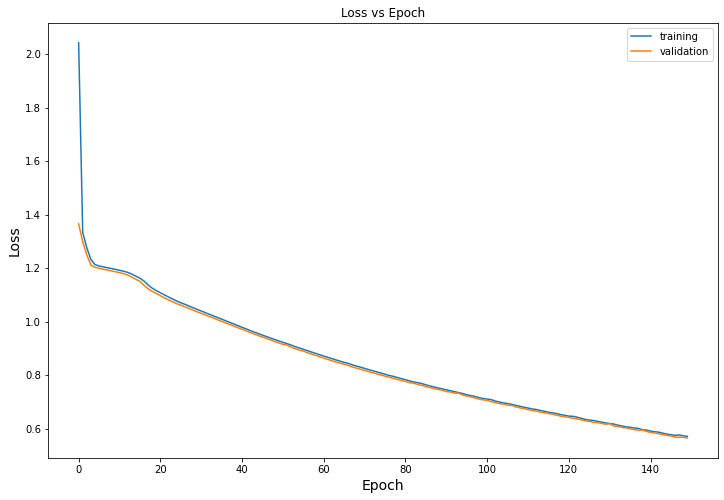

In [47]:
fig, axes = plt.subplots(figsize=(12, 8))
axes.set_ylabel("Loss", fontsize=14)
axes.set_xlabel("Epoch", fontsize=14)
axes.plot(train_loss_results,label="training")
axes.plot(val_loss_results,label="validation")
axes.legend(loc='best')
axes.set_title("Loss vs Epoch")
plt.show()